In [1]:
#Decoding with SVM averaged over 100 random seeds
#Decoding of 500 days of Summer vs other movies (only 2 classes) for significant channels only

In [ ]:
import os
import glob
import time 
import copy
import pickle
import random
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.inspection import permutation_importance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, roc_curve, auc, plot_confusion_matrix
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from mlxtend.plotting import plot_decision_regions

import utils.helper_func as hf
import utils.plotting as plotting
import utils.decoding as decoding

warnings.filterwarnings("ignore")

In [2]:
patient_id = 46
session_nr = 1

#top_dir = '/media/alado/TOSHIBA_EXT/thesis/output'
top_dir = '/home/anastasia/epiphyte/anastasia/output'
folder = f'05-Hilbert_transform_{patient_id}'
filtering_type = ['theta', 'slow_gamma', 'fast_gamma']

fs = 32768
#The resulting sample rate is up / down times the original sample rate.
up = 1
down=32
fs_downs = (up/down)*fs
dt = 1/fs_downs      # sampling period/time/interval or time resolution, often denoted as T

times = np.linspace(-500, 1000, num = 1501)
time_zero_idx = np.where(times == hf.find_nearest(times, 0))[0][0]

df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
dict_replace = {'LA1':'LAA1', 'LA2':'LAA2', 'LA3':'LAA3', 'LA4':'LAA4', 'LA5':'LAA5', 'LA6':'LAA6', 'LA7':'LAA7', 'LA8':'LAA8',
               'RA1':'RAA1', 'RA2':'RAA2', 'RA3':'RAA3', 'RA4':'RAA4', 'RA5':'RAA5', 'RA6':'RAA6', 'RA7':'RAA7', 'RA8':'RAA8',}
df_patient_info_new = df_patient_info.replace(dict_replace)
df_stim_info = pd.read_csv(f'{top_dir}/{patient_id}_df_stim_info.csv')
all_stim = np.unique(df_stim_info['stim_id'])
all_stim_name = np.unique(df_stim_info['stim_name'])
all_brain_areas = np.unique(df_patient_info_new['recording_site'])
#brain_areas = ['LAA', 'LAH', 'LEC','LMH', 'LPHC', 'RAA', 'RAH', 'REC', 'RMH', 'RPHC']
brain_areas = np.unique(df_patient_info['brain_area'])
selected_channels = ['CSC2', 'CSC8', 'CSC12', 'CSC26', 'CSC28', 'CSC29', 'CSC41', 'CSC42', 'CSC47', 'CSC52', 'CSC67']

n_channels = 80
n_stim_present = 10
n_stim = 42

In [3]:
time_chunks = ['200_500', '500_800', '200_600', '400_800']
time_chunks_dict = {'200_500_st':700, '200_500_end':1000, '500_800_st':1000, '500_800_end':1300, 
                    '200_600_st':700, '200_600_end':1100,'400_800_st':900, '400_800_end':1300}
n_pca_comp = 10

columns_data_array = []
for j in filtering_type:
    for i in range(len(df_patient_info['channel_name'])):
        ch = df_patient_info.loc[i,'channel_name']
        ch_site = df_patient_info.loc[i,'recording_site']
        
        for tm in time_chunks:
            columns_data_array.append(f'{j}_{ch}_{tm}_mean')
            columns_data_array.append(f'{j}_{ch}_{tm}_median')
            columns_data_array.append(f'{j}_{ch}_{tm}_variance')
            columns_data_array.append(f'{j}_{ch}_{tm}_rms')
        
        for comp in range(n_pca_comp):
            columns_data_array.append(f'{j}_{ch}_pca_{comp+1}')

In [4]:
for i in range(len(df_patient_info['channel_name'])):
    ch = df_patient_info.loc[i,'channel_name']
    ch_site = df_patient_info.loc[i,'recording_site']
    
    path = f'{top_dir}/{folder}/theta/envelope/{ch}_{ch_site}'
    file_1 = f'{path}/{ch}_{ch_site}_38_???_amplitude_envelope_pre.npy'
    file_2 = f'{path}/{ch}_{ch_site}_38_unknown_amplitude_envelope_pre.npy'
    os.rename(file_1, file_2)

FileNotFoundError: [Errno 2] No such file or directory: '/home/anastasia/epiphyte/anastasia/output/05-Hilbert_transform_46/theta/envelope/CSC1_LA1/CSC1_LA1_38_???_amplitude_envelope_pre.npy' -> '/home/anastasia/epiphyte/anastasia/output/05-Hilbert_transform_46/theta/envelope/CSC1_LA1/CSC1_LA1_38_unknown_amplitude_envelope_pre.npy'

In [5]:
if os.path.isfile(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv'):
    df_data_post = pd.read_csv(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv')
    df_stimuli = pd.read_csv(f'{top_dir}/06-decoding_{patient_id}/df_stimuli.csv')
else:
    n_pca_components = 10
    df_data_pre = decoding.create_data_df(df_stim_info, df_patient_info, all_stim, filtering_type, time_chunks, time_chunks_dict, columns_data_array, folder, n_pca_components, 'pre', pca_mode=True)
    df_data_post, df_stimuli = decoding.create_data_df(df_stim_info, df_patient_info, all_stim, filtering_type, time_chunks, time_chunks_dict, columns_data_array, folder, n_pca_components, 'post', pca_mode=True)
    df_data_post.to_csv(f'{top_dir}/06-decoding_{patient_id}/df_data_post.csv')
    df_stimuli.to_csv(f'{top_dir}/06-decoding_{patient_id}/df_stimuli.csv')

In [6]:
#percentage of stimuli
#movie vs non-movie
arr = [brain_areas[:5], brain_areas[5:]]
movie_stim = df_stimuli['is_500_days'].sum() / 10
movie_stim_percentage = (movie_stim*100)/42
non_movie_stim_percentage = 100 - movie_stim_percentage
non_movie_stim_percentage

23.80952380952381

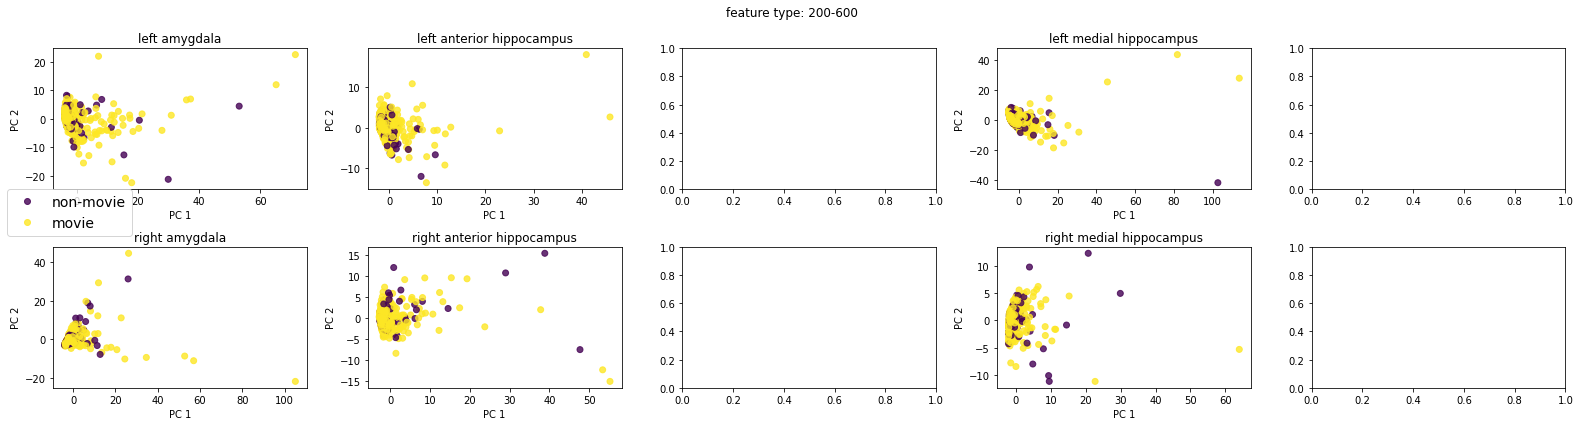

In [20]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(22,6))
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[(df_patient_info_new['brain_area'].str.contains(brain_area)) & (df_patient_info_new['channel_name'].isin(selected_channels))]
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                
                #for k in range (1, n_pca_components+1):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(k))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']
        
        if not X.empty:
            #2D PCA scatter plot
            pca = PCA(n_components=2)
            components = pca.fit_transform(X)

            scatter = axes[a,j].scatter(components[:,0], components[:,1], c=df_stimuli['is_500_days'], alpha=0.8)
            axes[a,j].set_title(f'{brain_area}')
            axes[a,j].set_xlabel('PC 1')
            axes[a,j].set_ylabel('PC 2')
            handles, labels = scatter.legend_elements()
            labels = ['non-movie', 'movie']
            #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/post_data_PCA_{feature_type}.png', facecolor='white', transparent=False)

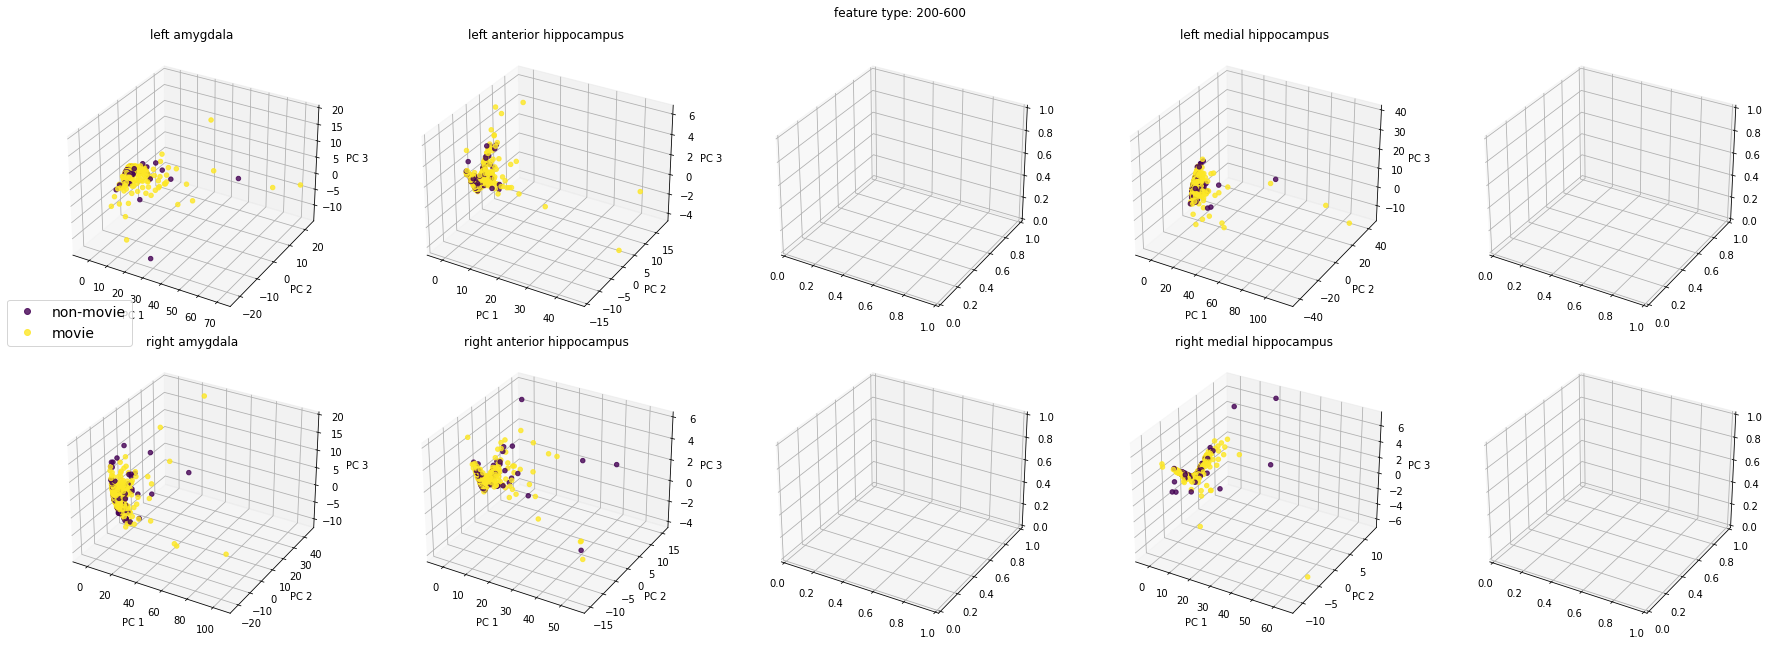

In [21]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(25,9), subplot_kw={"projection": "3d"})
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[(df_patient_info_new['brain_area'].str.contains(brain_area)) & (df_patient_info_new['channel_name'].isin(selected_channels))]            
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                 
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']
        
        if not X.empty:
            #3D PCA scatter plot
            pca = PCA(n_components=3)
            components = pca.fit_transform(X)

            scatter = axes[a,j].scatter(components[:,0], components[:,1], components[:,2], c=df_stimuli['is_500_days'], alpha=0.8)
            axes[a,j].set_title(f'{brain_area}')
            axes[a,j].set_xlabel('PC 1')
            axes[a,j].set_ylabel('PC 2')
            axes[a,j].set_zlabel('PC 3')
            handles, labels = scatter.legend_elements()
            labels = ['non-movie', 'movie']
            #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/pre_data_PCA3_{feature_type}.png', facecolor='white', transparent=False)


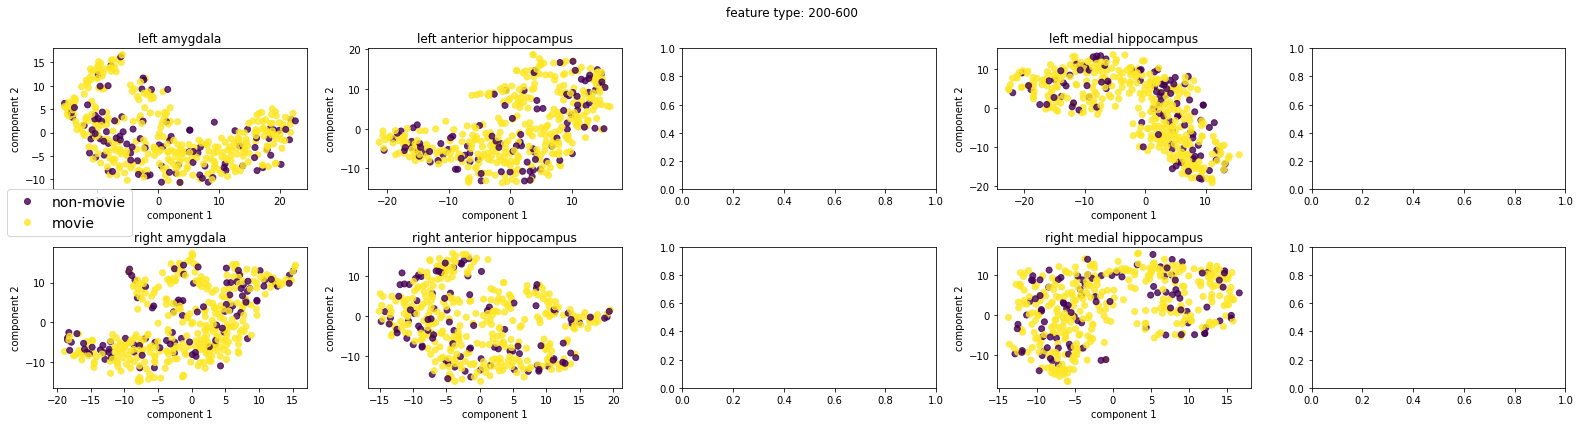

In [22]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(22,6))
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[(df_patient_info_new['brain_area'].str.contains(brain_area)) & (df_patient_info_new['channel_name'].isin(selected_channels))]            
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')             
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']
        
        if not X.empty:
            #2D t-SNE
            tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=5000)
            tsne_results = tsne.fit_transform(X)

            scatter = axes[a,j].scatter(tsne_results[:,0], tsne_results[:,1], c=df_stimuli['is_500_days'], alpha=0.8)
            axes[a,j].set_title(f'{brain_area}')
            axes[a,j].set_xlabel('component 1')
            axes[a,j].set_ylabel('component 2')
            handles, labels = scatter.legend_elements()
            labels = ['non-movie', 'movie']
            #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/post_data_tSNE_{feature_type}.png', facecolor='white', transparent=False)

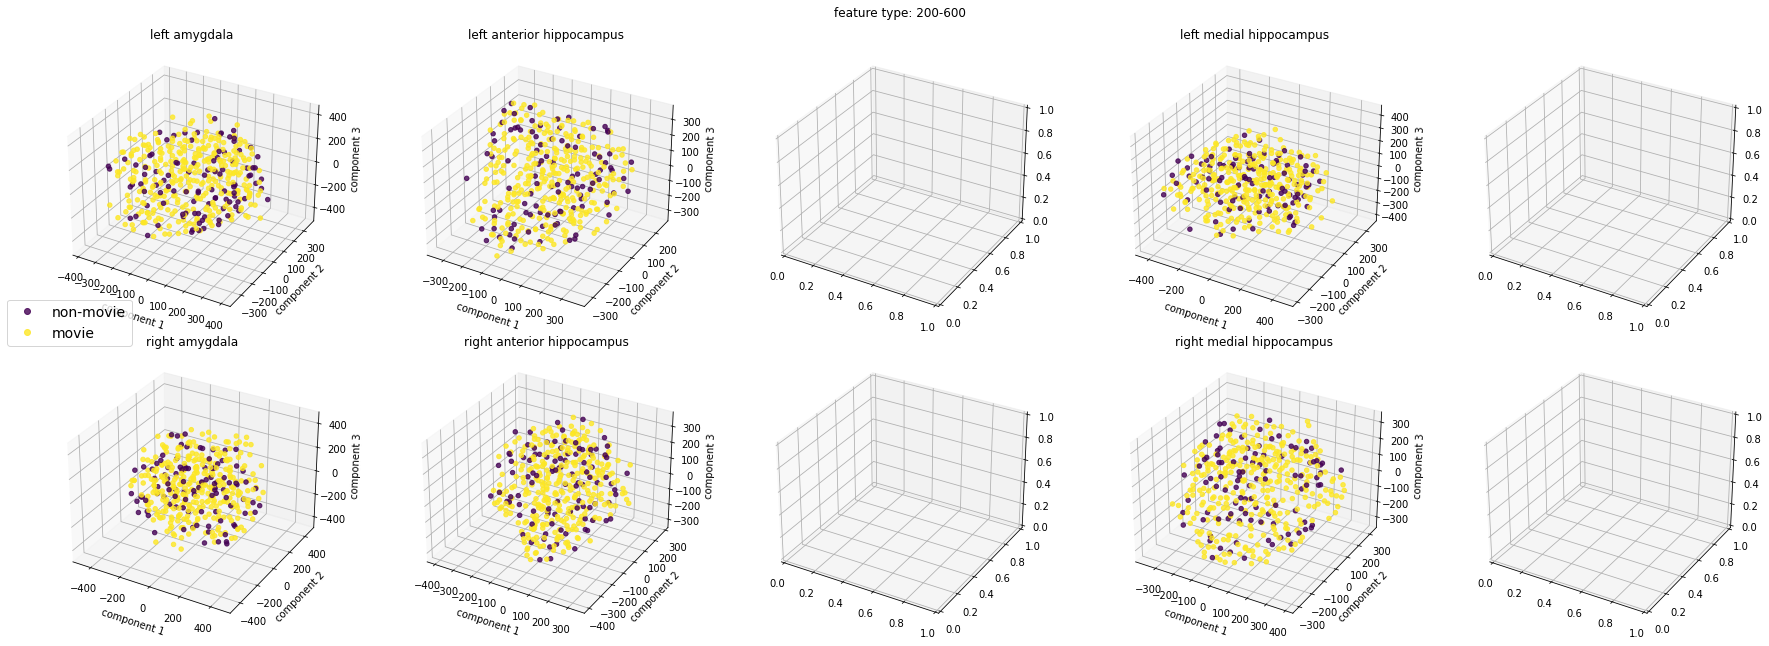

In [23]:
classes = ['non-movie', 'movie']
fig, axes = plt.subplots(2,5, figsize=(25,9), subplot_kw={"projection": "3d"})
feature_type = '200-600'
fig.suptitle(f'feature type: {feature_type}')
for a in range(len(arr)):
    br_areas = arr[a]
    for j in range(len(br_areas)):
        if a == 0:
            brain_area = brain_areas[j]
        else:
            brain_area = brain_areas[j+5]
        channel_cols = df_patient_info.loc[(df_patient_info_new['brain_area'].str.contains(brain_area)) & (df_patient_info_new['channel_name'].isin(selected_channels))]            
        channel_cols = channel_cols.reset_index()
        cols_to_use = []
        for filt in filtering_type:
            for i in range(len(channel_cols)):
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
                cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_400_800') 
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_500')
                #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')                 
                #for j in range (1, n_pca_components):
                #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

        #for multiclass one-vs-one: belongs to movie or not
        X = df_data_post[df_data_post.columns & cols_to_use]
        y = df_stimuli['is_500_days']
        
        if not X.empty:
            #3D t-SNE scatter plot
            tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=5000)
            tsne_results = tsne.fit_transform(X)

            scatter = axes[a,j].scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=df_stimuli['is_500_days'], alpha=0.8)
            axes[a,j].set_title(f'{brain_area}')
            axes[a,j].set_xlabel('component 1')
            axes[a,j].set_ylabel('component 2')
            axes[a,j].set_zlabel('component 3')
            handles, labels = scatter.legend_elements()
            labels = ['non-movie', 'movie']
            #axes[a,j].legend(handles, labels)

plt.tight_layout()
fig.legend(handles, labels, loc='center left', prop={'size': 14})
plt.show()
fig.savefig(f'{top_dir}/06-decoding_{patient_id}/plots/data/pre_data_tSNE3_{feature_type}.png', facecolor='white', transparent=False)

brain area: left amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: left anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: right anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left amygdala
best classifier: [0.0001, 'poly']
mean accuracy: 0.42±0.25
mean balanced accuracy: 0.49±0.01
mean recall: 0.35±0.46
mean precision: 0.39±0.36
mean F1: 0.3±0.27
mean kappa: -0.01±0

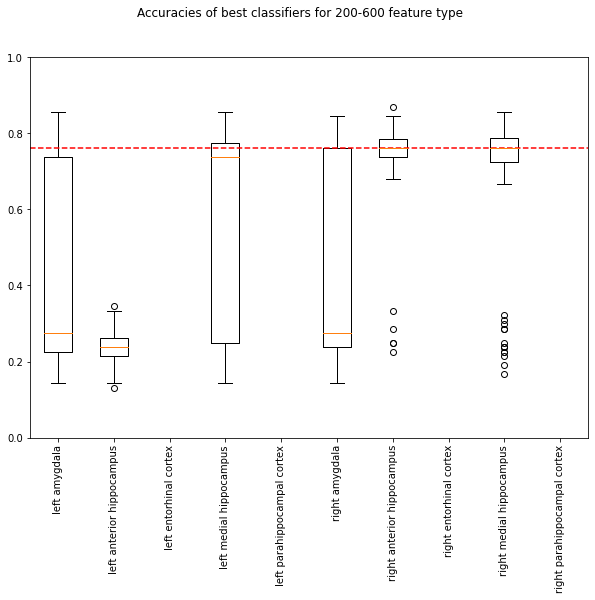

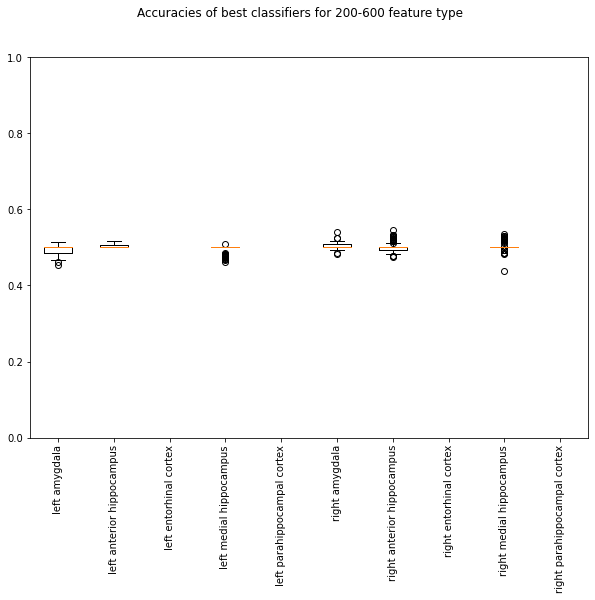

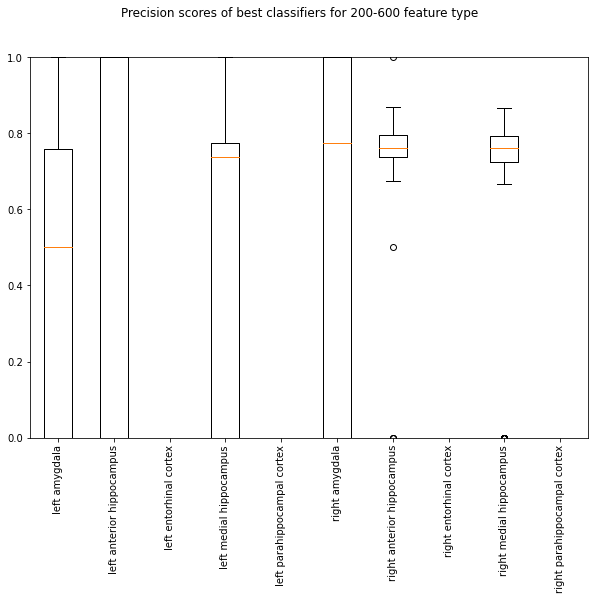

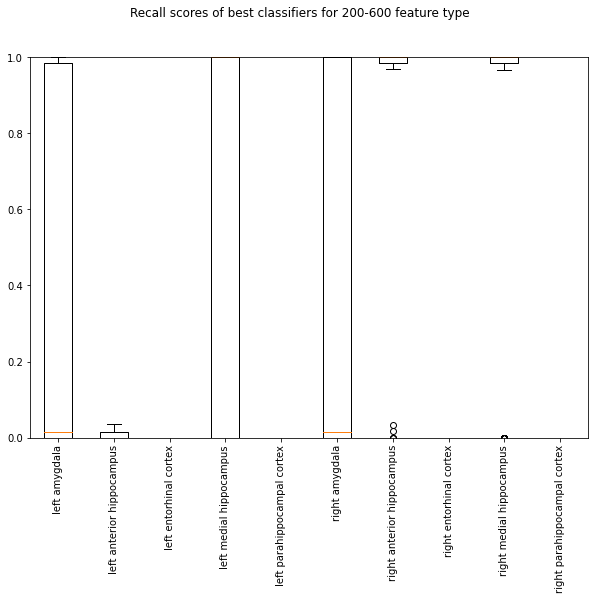

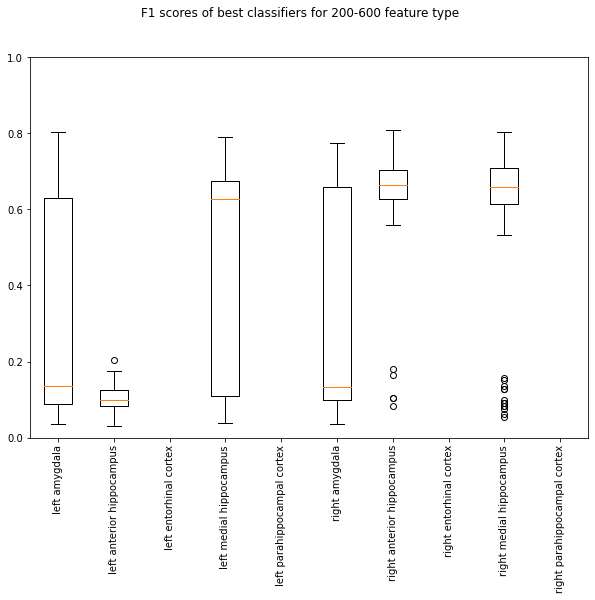

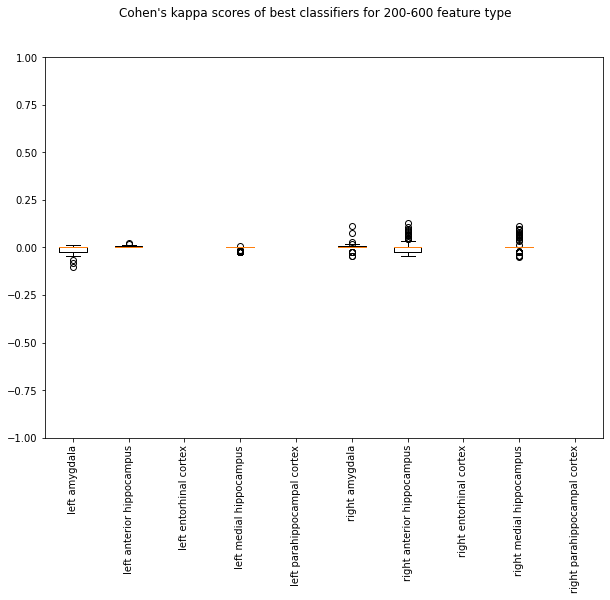

In [8]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[(df_patient_info_new['brain_area'].str.contains(brain_area)) & (df_patient_info_new['channel_name'].isin(selected_channels))]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')
            #cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_500_800')            
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
    
    if not X.empty:
        for rand_seed in random_seeds:
            np.random.seed(rand_seed) #for train-test split
            strings.append(rand_seed)
            best_params = {}

            # Use a K-fold cross validation with different parameters
            # Create all parameter combinations
            params = {'random_state': [rand_seed],
                      'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                      'loss': ['hinge', 'squared_hinge'],    
                      'penalty': ['l1', 'l2'],
                      #'gamma': ['scale', 'auto'],
                      #'degree': [3]
                     }
            # Create all possible parameter combinations
            combinations_linear = [[i, j, k, l] for i in params['random_state']
                           for j in params['C']
                           for k in params['loss']
                           for l in params ['penalty']]
            for s in reversed(combinations_linear):
                if (s[2] == 'hinge') and (s[3]=='l1'):
                    combinations_linear.remove(s)
            combinations = [[i, j] for i in params['random_state']
                           for j in params['C']
                           #for l in params['gamma']
                           #for k in params['degree']
                           ]

            for kernel in kernels:
                if kernel == 'linear':
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'oversampling')
                else:
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'oversampling') 

                all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: left anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: right anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left amygdala
best classifier: [0.0001, 'poly']
mean accuracy: 0.37±0.22
mean balanced accuracy: 0.5±0.02
mean recall: 0.26±0.4
mean precision: 0.68±0.3
mean F1: 0.26±0.23
mean kappa: -0.0±0.02

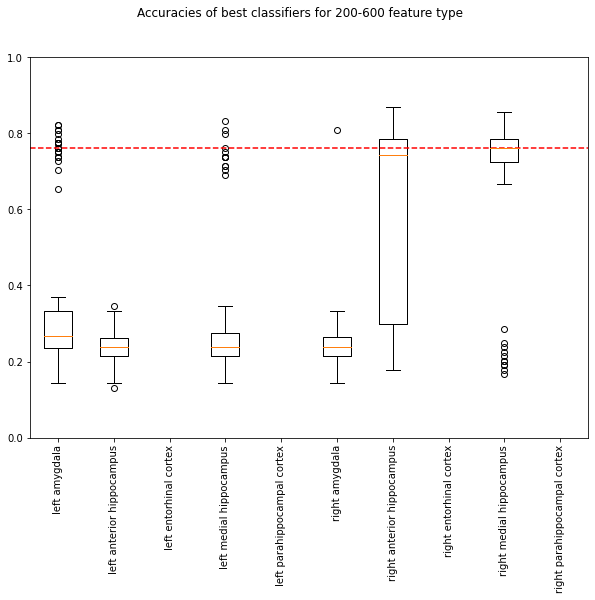

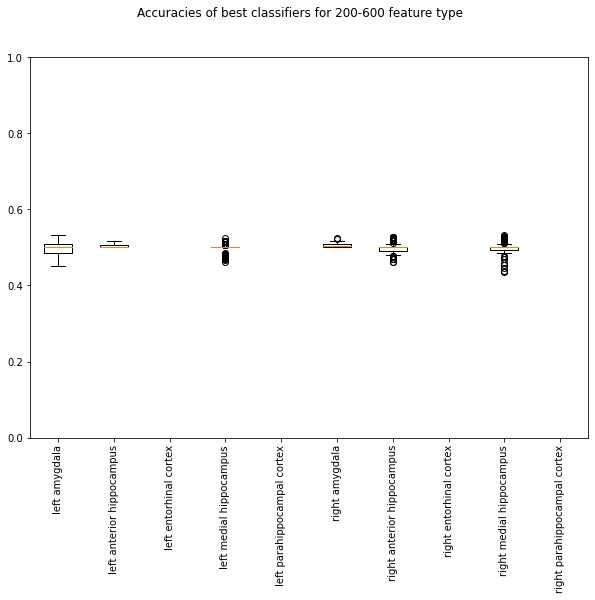

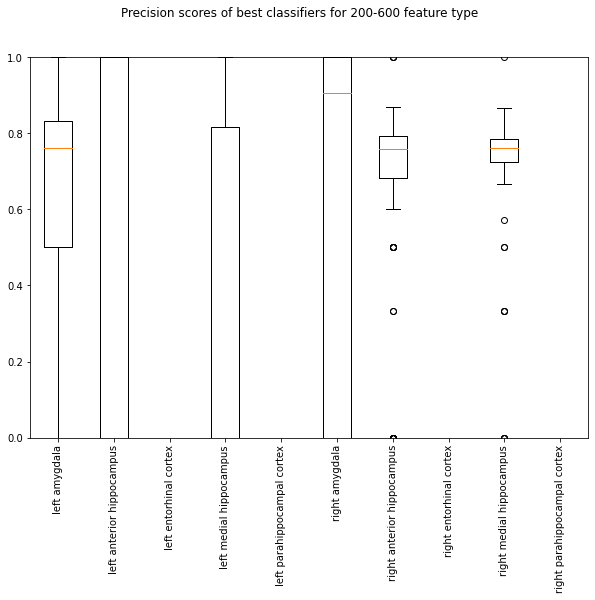

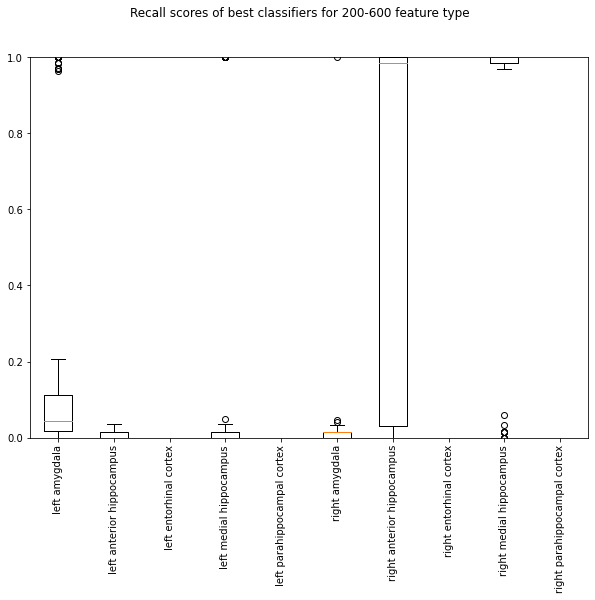

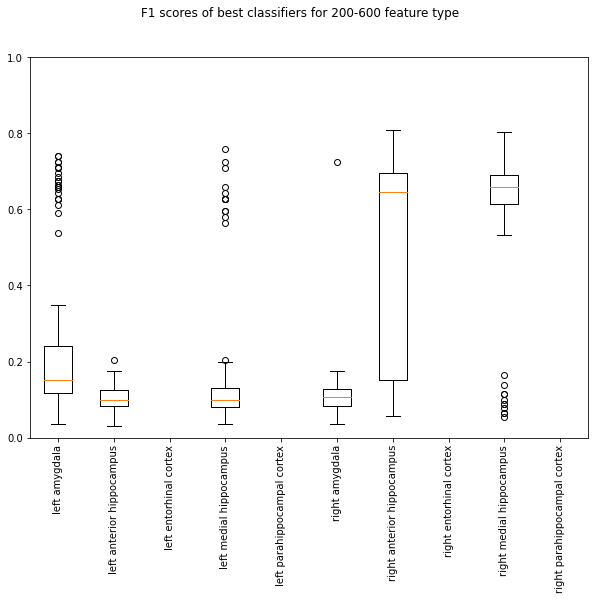

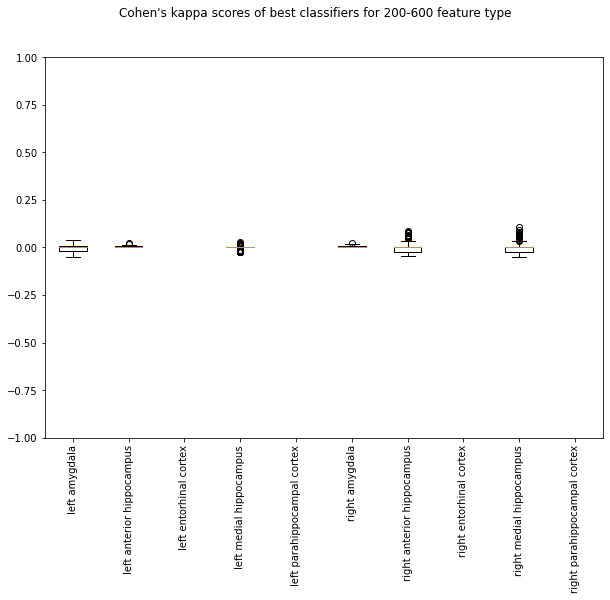

In [9]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[(df_patient_info_new['brain_area'].str.contains(brain_area)) & (df_patient_info_new['channel_name'].isin(selected_channels))]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')            
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
    
    if not X.empty: 
        for rand_seed in random_seeds:
            np.random.seed(rand_seed) #for train-test split
            strings.append(rand_seed)
            best_params = {}

            # Use a K-fold cross validation with different parameters
            # Create all parameter combinations
            params = {'random_state': [rand_seed],
                      'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                      'loss': ['hinge', 'squared_hinge'],    
                      'penalty': ['l1', 'l2'],
                      #'gamma': ['scale', 'auto'],
                      #'degree': [3]
                     }
            # Create all possible parameter combinations
            combinations_linear = [[i, j, k, l] for i in params['random_state']
                           for j in params['C']
                           for k in params['loss']
                           for l in params ['penalty']]
            for s in reversed(combinations_linear):
                if (s[2] == 'hinge') and (s[3]=='l1'):
                    combinations_linear.remove(s)
            combinations = [[i, j] for i in params['random_state']
                           for j in params['C']
                           #for l in params['gamma']
                           #for k in params['degree']
                           ]

            for kernel in kernels:
                if kernel == 'linear':
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'SMOTETomek')
                else:
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'SMOTETomek') 

                all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: left anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: right anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left amygdala
best classifier: [0.0001, 'poly']
mean accuracy: 0.76±0.04
mean balanced accuracy: 0.5±0.01
mean recall: 0.98±0.02
mean precision: 0.77±0.04
mean F1: 0.67±0.05
mean kappa: 0.01±0.

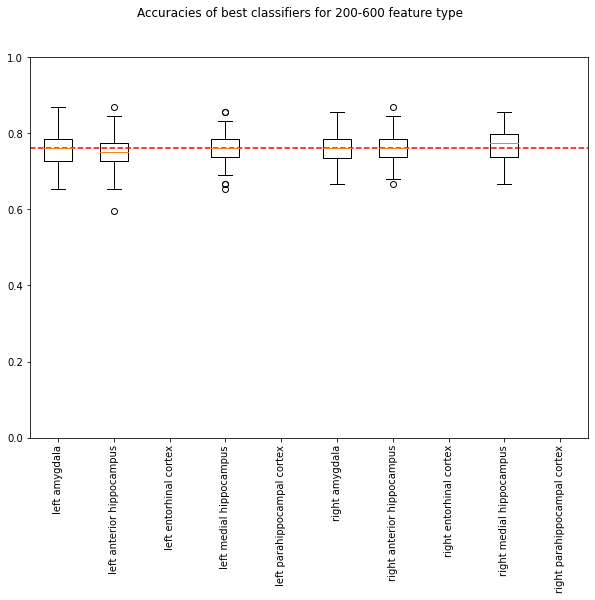

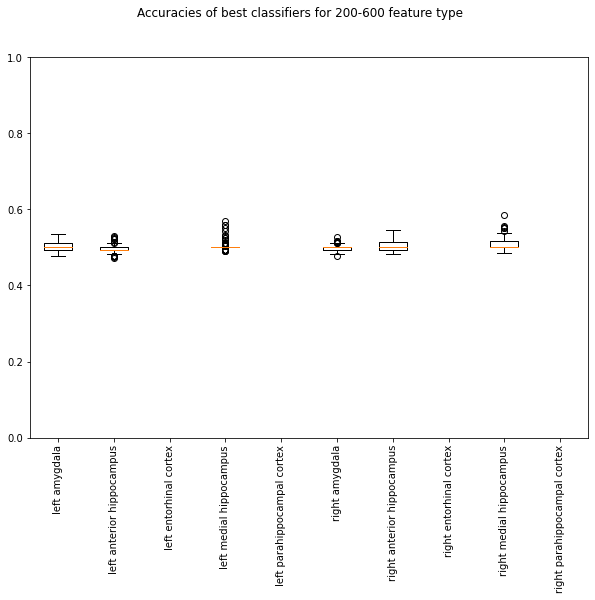

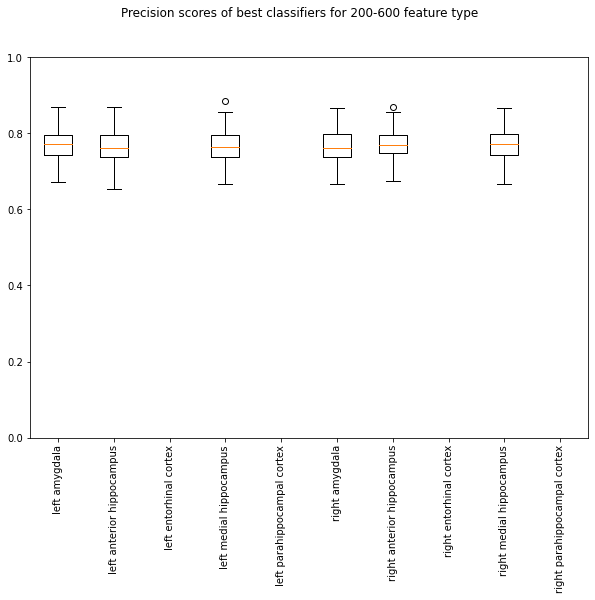

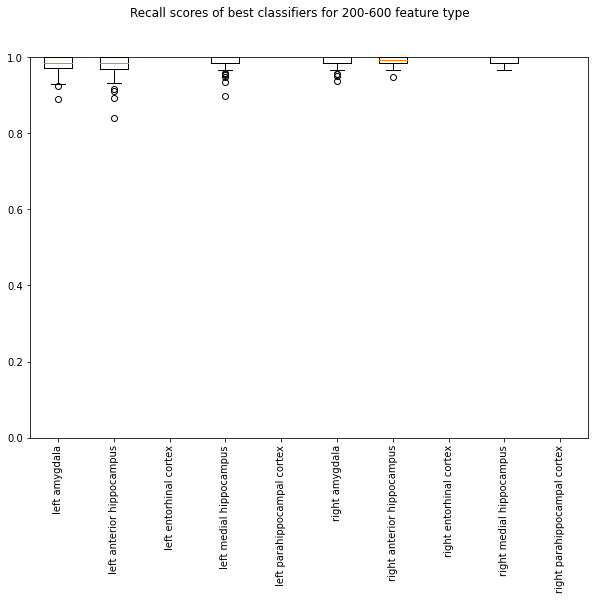

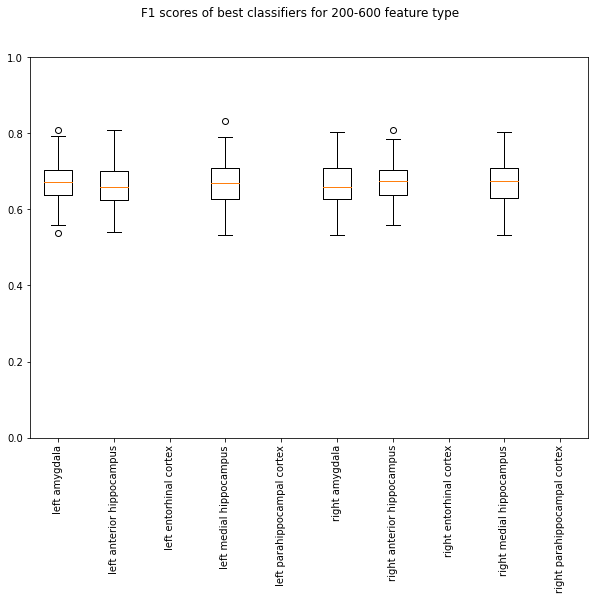

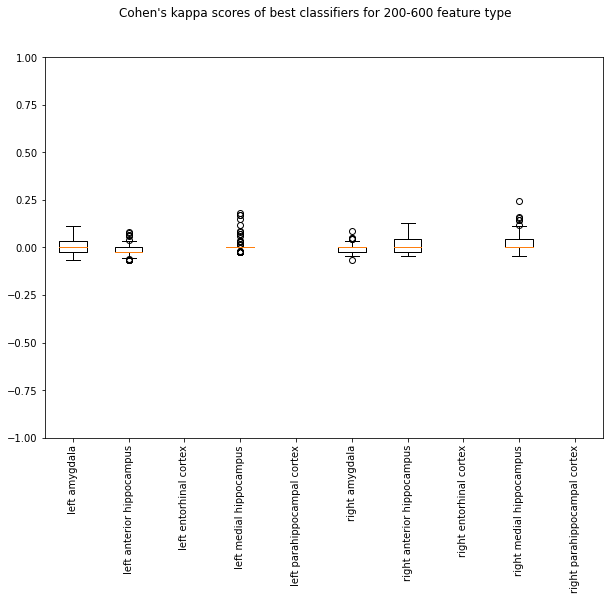

In [10]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[(df_patient_info_new['brain_area'].str.contains(brain_area)) & (df_patient_info_new['channel_name'].isin(selected_channels))]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')            
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
    
    if not X. empty:
        for rand_seed in random_seeds:
            np.random.seed(rand_seed) #for train-test split
            strings.append(rand_seed)
            best_params = {}

            # Use a K-fold cross validation with different parameters
            # Create all parameter combinations
            params = {'random_state': [rand_seed],
                      'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                      'loss': ['hinge', 'squared_hinge'],    
                      'penalty': ['l1', 'l2'],
                      #'gamma': ['scale', 'auto'],
                      #'degree': [3]
                     }
            # Create all possible parameter combinations
            combinations_linear = [[i, j, k, l] for i in params['random_state']
                           for j in params['C']
                           for k in params['loss']
                           for l in params ['penalty']]
            for s in reversed(combinations_linear):
                if (s[2] == 'hinge') and (s[3]=='l1'):
                    combinations_linear.remove(s)
            combinations = [[i, j] for i in params['random_state']
                           for j in params['C']
                           #for l in params['gamma']
                           #for k in params['degree']
                           ]

            for kernel in kernels:
                if kernel == 'linear':
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'NearMiss')
                else:
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'NearMiss') 

                all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_balanced_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: left anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: right anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left amygdala
best classifier: [0.0001, 'poly']
mean accuracy: 0.37±0.23
mean balanced accuracy: 0.5±0.01
mean recall: 0.25±0.43
mean precision: 0.41±0.41
mean F1: 0.24±0.25
mean kappa: -0.01±0

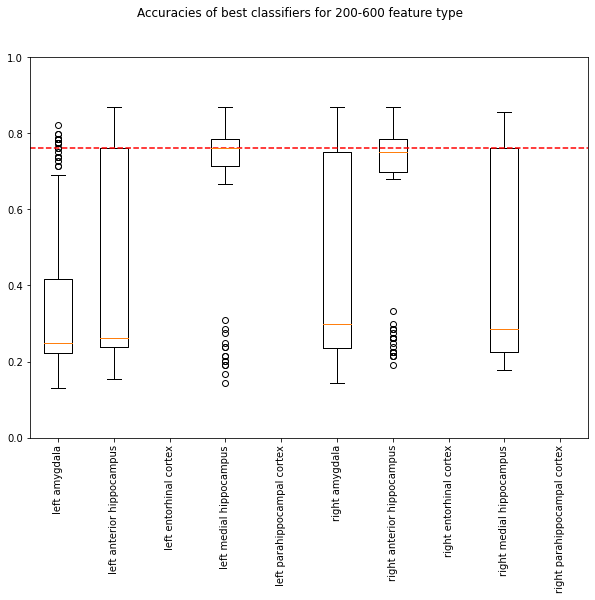

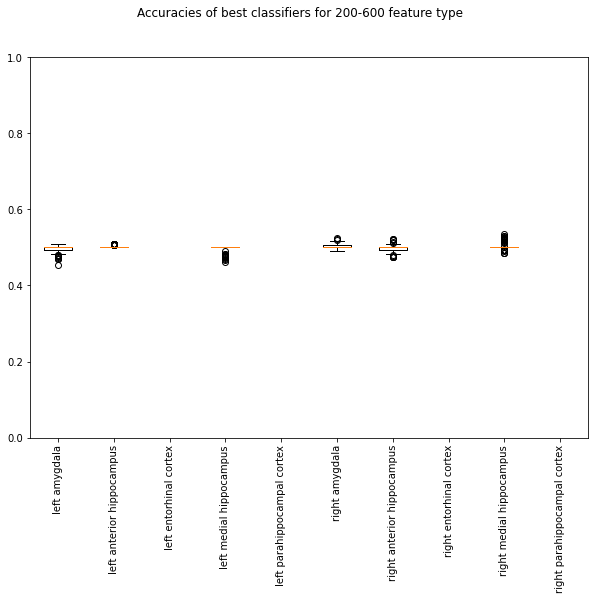

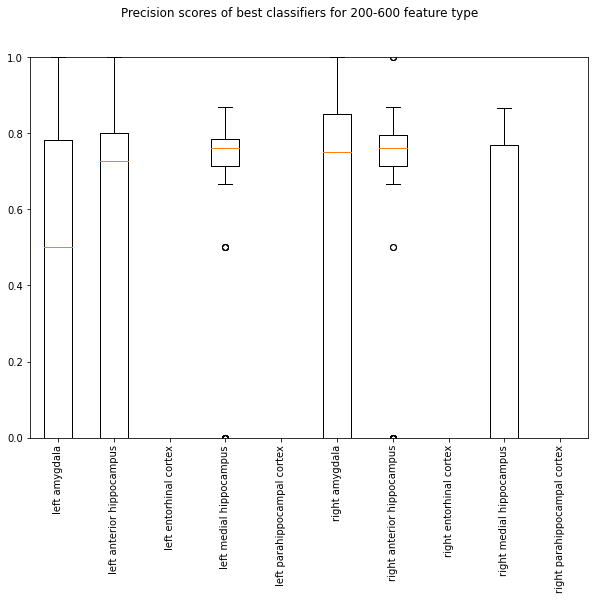

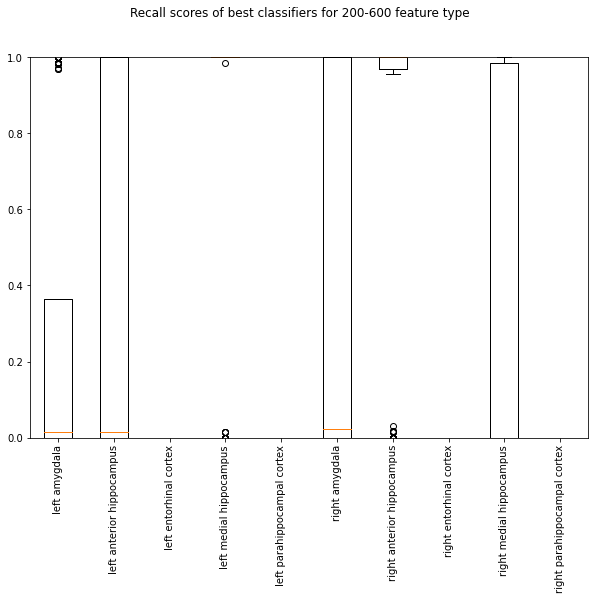

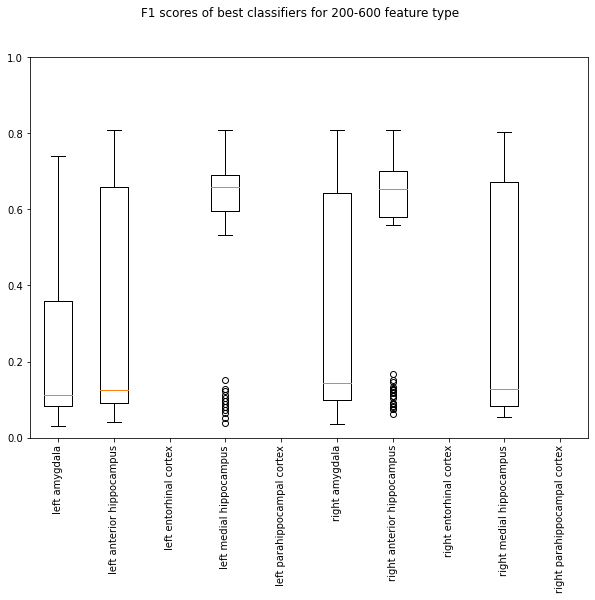

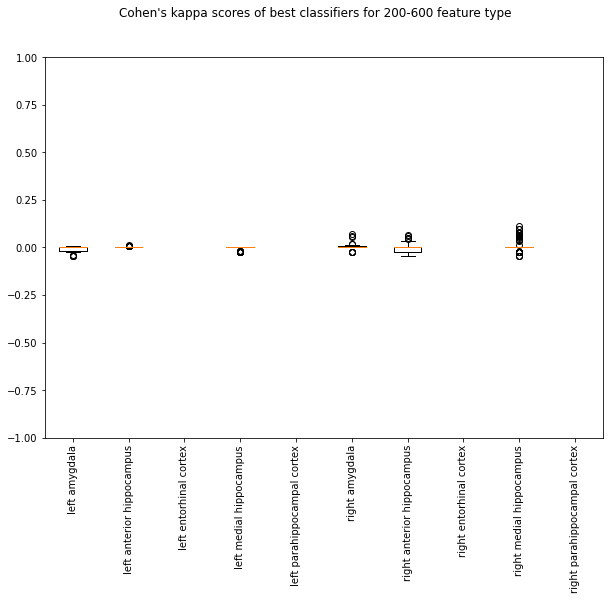

In [11]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[(df_patient_info_new['brain_area'].str.contains(brain_area)) & (df_patient_info_new['channel_name'].isin(selected_channels))]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')             
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
    
    if not X.empty:
        for rand_seed in random_seeds:
            np.random.seed(rand_seed) #for train-test split
            strings.append(rand_seed)
            best_params = {}

            # Use a K-fold cross validation with different parameters
            # Create all parameter combinations
            params = {'random_state': [rand_seed],
                      'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                      'loss': ['hinge', 'squared_hinge'],    
                      'penalty': ['l1', 'l2'],
                      #'gamma': ['scale', 'auto'],
                      #'degree': [3]
                     }
            # Create all possible parameter combinations
            combinations_linear = [[i, j, k, l] for i in params['random_state']
                           for j in params['C']
                           for k in params['loss']
                           for l in params ['penalty']]
            for s in reversed(combinations_linear):
                if (s[2] == 'hinge') and (s[3]=='l1'):
                    combinations_linear.remove(s)
            combinations = [[i, j] for i in params['random_state']
                           for j in params['C']
                           #for l in params['gamma']
                           #for k in params['degree']
                           ]

            for kernel in kernels:
                if kernel == 'linear':
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'CondensedNN')
                else:
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'CondensedNN') 

                all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)

brain area: left amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: left anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: left parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right amygdala
best classifier: [0.0001, 'poly']
loss: nan
brain area: right anterior hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right entorhinal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: right medial hippocampus
best classifier: [0.0001, 'poly']
loss: nan
brain area: right parahippocampal cortex
best classifier: [0.0001, 'poly']
loss: nan
brain area: left amygdala
best classifier: [0.0001, 'poly']
mean accuracy: 0.24±0.04
mean balanced accuracy: 0.5±0.01
mean recall: 0.01±0.01
mean precision: 0.36±0.44
mean F1: 0.1±0.03
mean kappa: -0.0±0.0

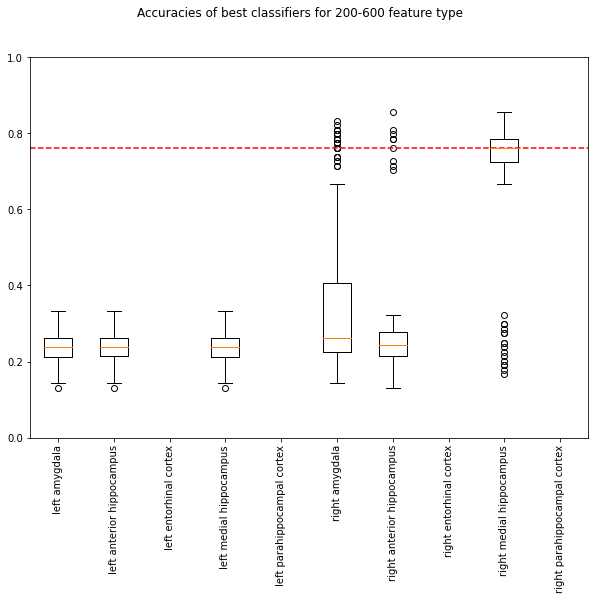

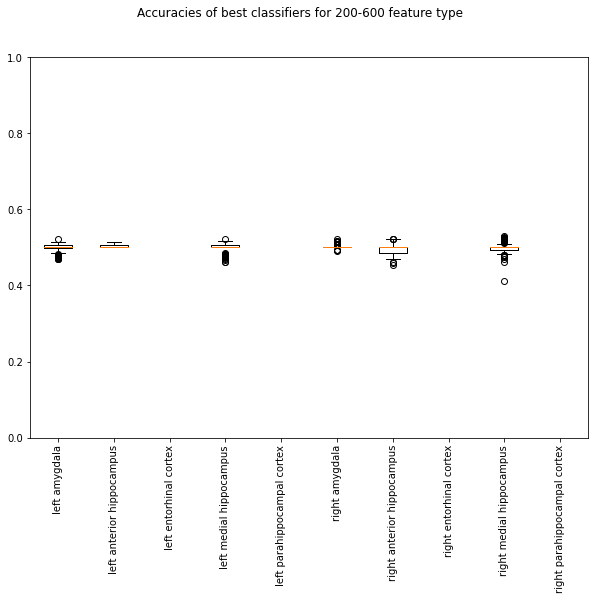

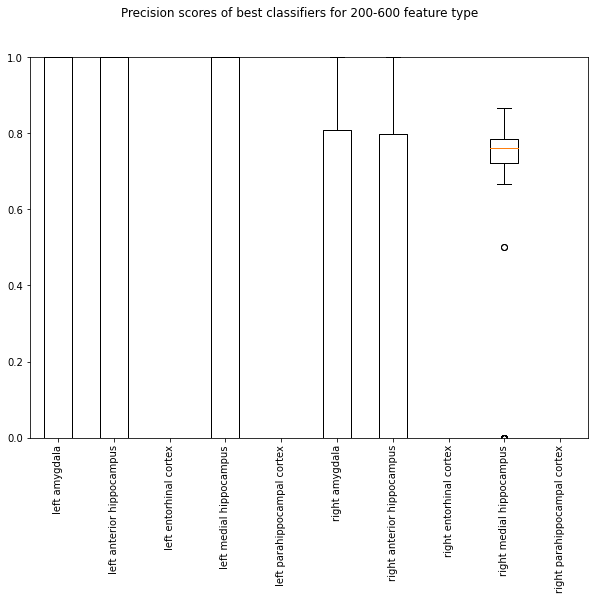

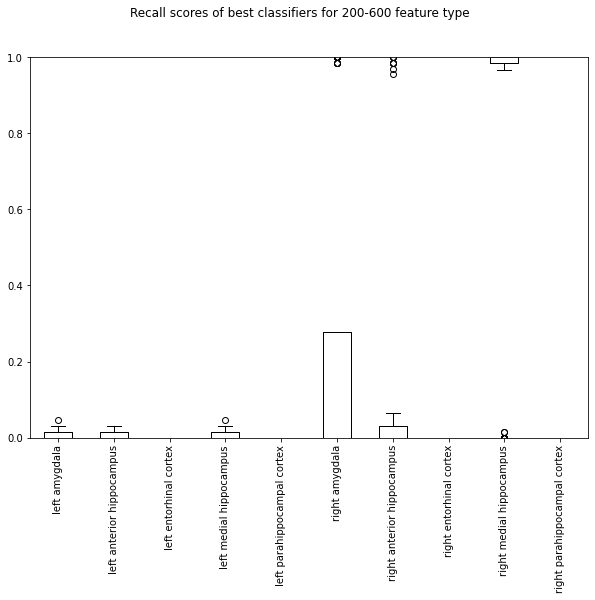

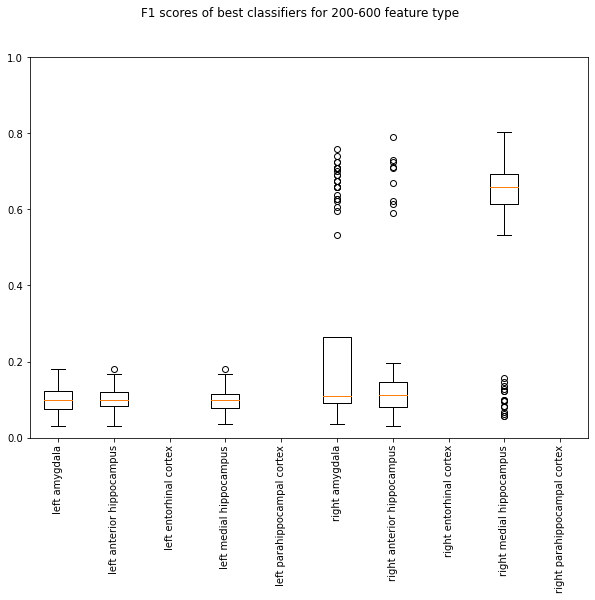

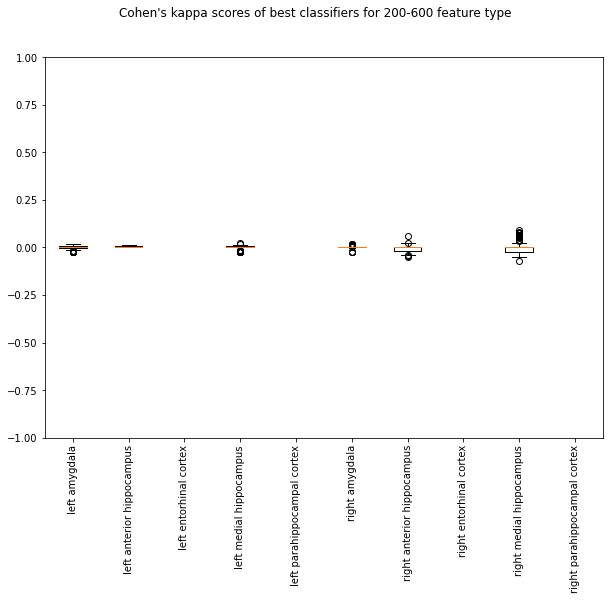

In [12]:
#NEW
#random_seeds = [1, 10, 42, 86, 100]
#random_seeds = [1, 10]
random_seeds = np.linspace(1, 500, 100, dtype=int)
kernels = ['poly', 'linear', 'rbf', 'sigmoid']
strings = []
all_best_params_list = []
best_params_list = []
all_losses = []
feature_type = '200-600'

for brain_area in brain_areas:
    best_params_list_per_area = []
    best_classifier = []
    strings.append(brain_area)
    channel_cols = df_patient_info.loc[(df_patient_info_new['brain_area'].str.contains(brain_area)) & (df_patient_info_new['channel_name'].isin(selected_channels))]
    channel_cols = channel_cols.reset_index()

    cols_to_use = []
    for filt in filtering_type:
        for i in range(len(channel_cols)):
            #print(for_cols.loc[i,'channel_name'])
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_mean')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_median')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_variance')
            cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_200_600'+'_rms')             
            #for j in range (1, n_pca_components):
            #    cols_to_use.append(filt+'_'+channel_cols.loc[i,'channel_name']+'_pca_'+str(j))

    X = df_data_post[df_data_post.columns & cols_to_use]
    y = df_stimuli['is_500_days']
    
    if not X.empty:
        for rand_seed in random_seeds:
            np.random.seed(rand_seed) #for train-test split
            strings.append(rand_seed)
            best_params = {}

            # Use a K-fold cross validation with different parameters
            # Create all parameter combinations
            params = {'random_state': [rand_seed],
                      'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                      'loss': ['hinge', 'squared_hinge'],    
                      'penalty': ['l1', 'l2'],
                      #'gamma': ['scale', 'auto'],
                      #'degree': [3]
                     }
            # Create all possible parameter combinations
            combinations_linear = [[i, j, k, l] for i in params['random_state']
                           for j in params['C']
                           for k in params['loss']
                           for l in params ['penalty']]
            for s in reversed(combinations_linear):
                if (s[2] == 'hinge') and (s[3]=='l1'):
                    combinations_linear.remove(s)
            combinations = [[i, j] for i in params['random_state']
                           for j in params['C']
                           #for l in params['gamma']
                           #for k in params['degree']
                           ]

            for kernel in kernels:
                if kernel == 'linear':
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations_linear, kernel, rand_seed, 'NeighbourhoodCleaningRule')
                else:
                    losses, classifier = decoding.custom_SVM_one_run_resampling(X, y, combinations, kernel, rand_seed, 'NeighbourhoodCleaningRule') 

                all_losses.append([losses, brain_area])

params = {'C': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
          'loss': ['hinge', 'squared_hinge'],    
          'penalty': ['l1', 'l2'],
          #'gamma': ['scale', 'auto'],
          #'degree': [3]
         }
# Create all possible parameter combinations
comb_linear = [[i, j, k] for i in params['C']
               for j in params['loss']
               for k in params ['penalty']]
for s in reversed(comb_linear):
    if (s[1] == 'hinge') and (s[2]=='l1'):
        comb_linear.remove(s)
comb_rest = [[i] for i in params['C']
               #for l in params['gamma']
               #for k in params['degree']
               ]

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots/{feature_type}'
decoding.print_avg_accuracies_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_precisions_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_recalls_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_f1s_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)
decoding.print_avg_kappas_per_area(all_losses, comb_linear, comb_rest, kernels, brain_areas, movie_stim_percentage, fig_save_path)

best_clfs = decoding.select_clf_lowest_loss(all_losses, comb_linear, comb_rest, kernels, brain_areas)

fig_save_path = f'{top_dir}/06-decoding_{patient_id}/plots_best/{feature_type}'
decoding.print_best_clfs_per_area(all_losses, best_clfs, brain_areas, feature_type, movie_stim_percentage, fig_save_path)